In [19]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Understanding The Data

In [20]:
# data pre-processing of the family income / comfortability dataset
df = pd.read_excel("fbc_data_2024.xlsx", sheet_name='County', header=1)
ut_df = df[df["State abv."] == 'UT']
cache_county_df = ut_df[ut_df['County'] == 'Cache County']


Costs for Cache County:
	Family Type: 1p0c, Monthly Cost: $3457, Yearly Cost: $41484
	Family Type: 1p1c, Monthly Cost: $5450, Yearly Cost: $65400
	Family Type: 1p2c, Monthly Cost: $7132, Yearly Cost: $85584
	Family Type: 1p3c, Monthly Cost: $8934, Yearly Cost: $107208
	Family Type: 1p4c, Monthly Cost: $9779, Yearly Cost: $117348
	Family Type: 2p0c, Monthly Cost: $4706, Yearly Cost: $56472
	Family Type: 2p1c, Monthly Cost: $6534, Yearly Cost: $78408
	Family Type: 2p2c, Monthly Cost: $7950, Yearly Cost: $95400
	Family Type: 2p3c, Monthly Cost: $9564, Yearly Cost: $114768
	Family Type: 2p4c, Monthly Cost: $10456, Yearly Cost: $125472


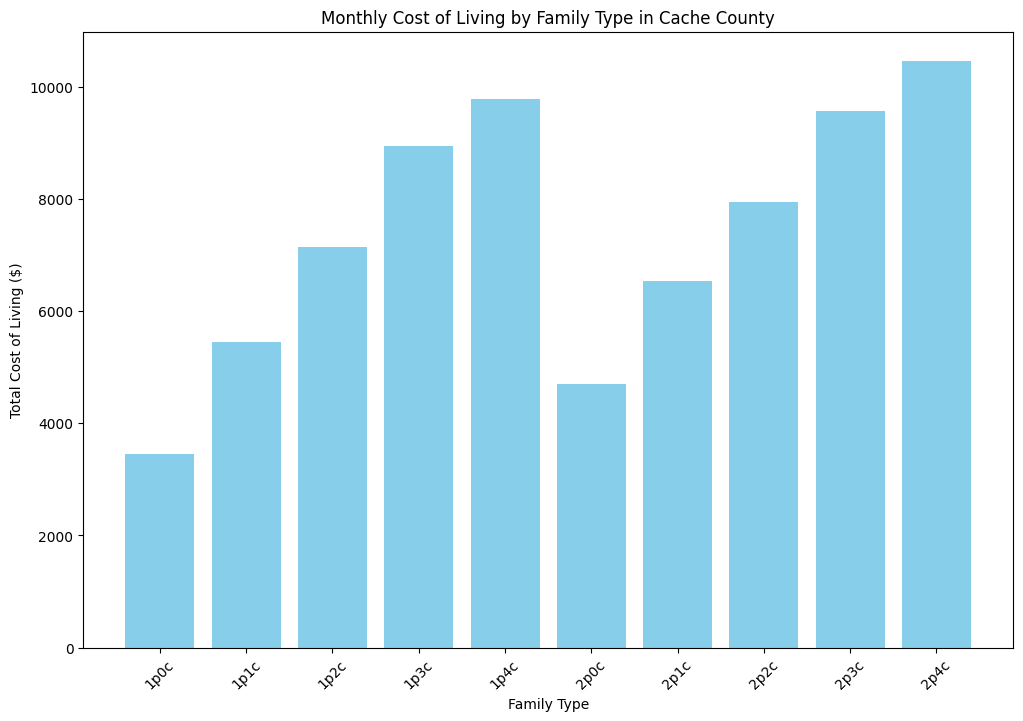

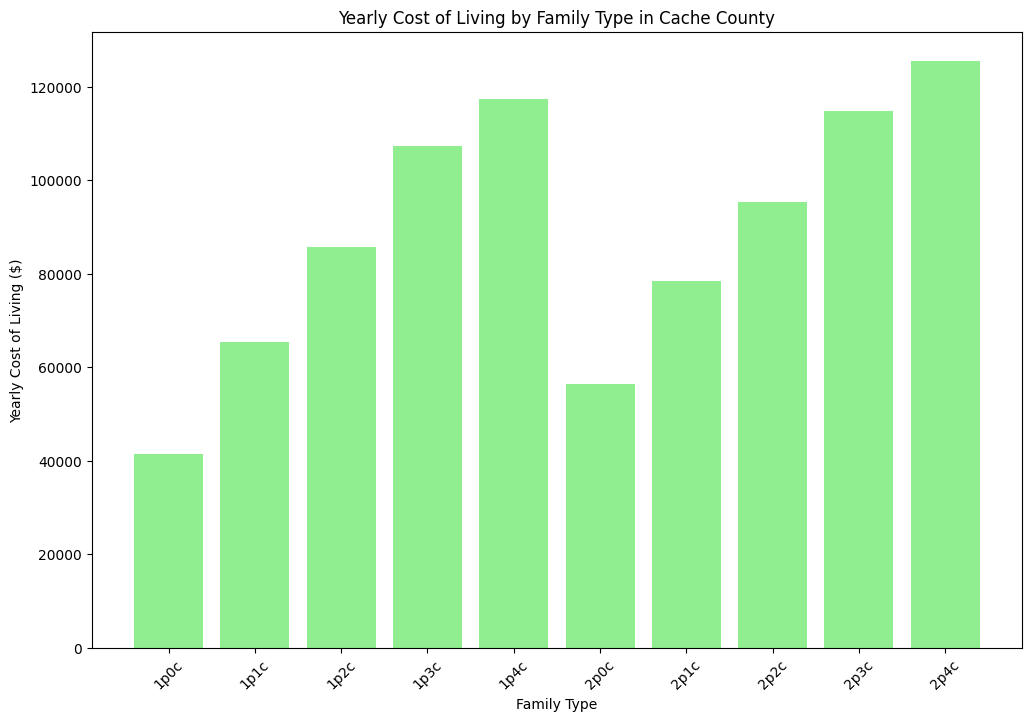


Costs for Salt Lake County:
	Family Type: 1p0c, Monthly Cost: $3961, Yearly Cost: $47532
	Family Type: 1p1c, Monthly Cost: $6262, Yearly Cost: $75144
	Family Type: 1p2c, Monthly Cost: $7882, Yearly Cost: $94584
	Family Type: 1p3c, Monthly Cost: $9964, Yearly Cost: $119568
	Family Type: 1p4c, Monthly Cost: $10863, Yearly Cost: $130356
	Family Type: 2p0c, Monthly Cost: $5375, Yearly Cost: $64500
	Family Type: 2p1c, Monthly Cost: $7191, Yearly Cost: $86292
	Family Type: 2p2c, Monthly Cost: $8573, Yearly Cost: $102876
	Family Type: 2p3c, Monthly Cost: $10587, Yearly Cost: $127044
	Family Type: 2p4c, Monthly Cost: $11465, Yearly Cost: $137580


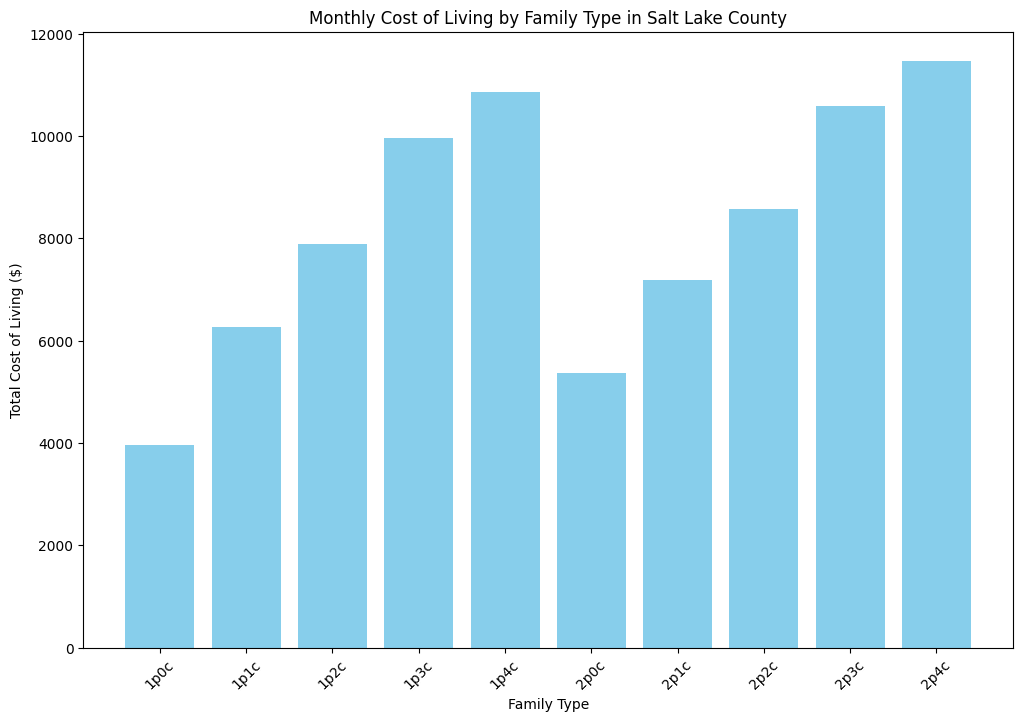

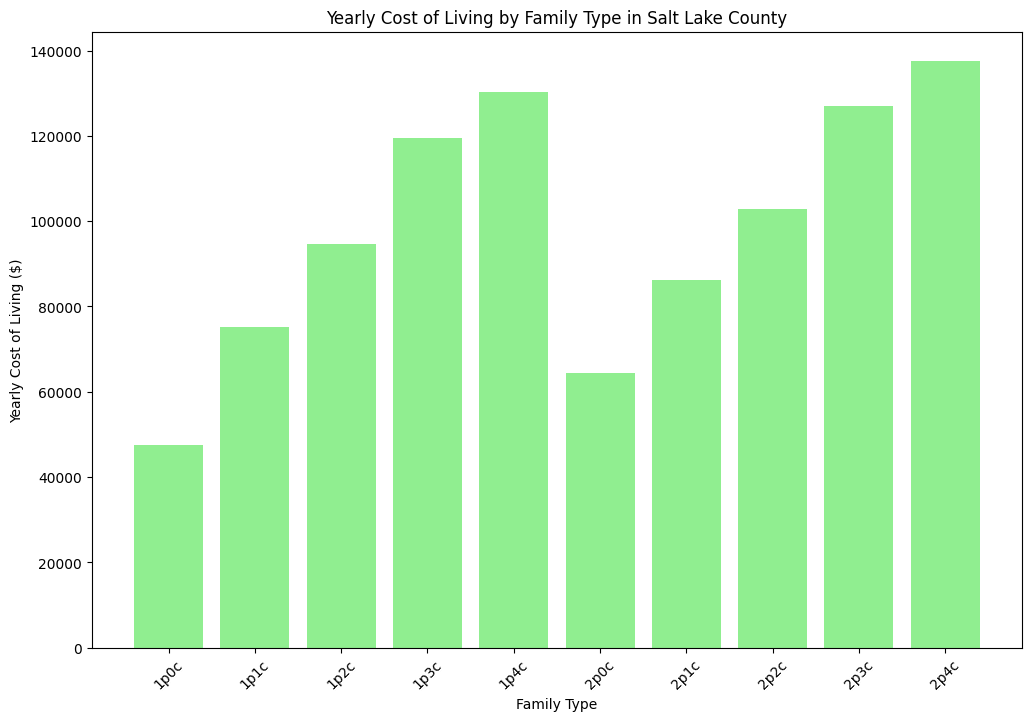

In [21]:
def CostOfLivingPerCounty(county_name, plot=False):
    specific_county_df = ut_df[ut_df['County'] == county_name]
    family_types = specific_county_df['Family']
    
    monthly_total_costs = specific_county_df['Total']
    yearly_total_costs = specific_county_df['Total.1']

    print(f"\nCosts for {county_name}:")
    for family, monthly_cost, yearly_cost in zip(family_types, monthly_total_costs, yearly_total_costs):
        print(f"\tFamily Type: {family}, Monthly Cost: ${monthly_cost}, Yearly Cost: ${yearly_cost}")

    if (plot):
        # Monthly costs
        plt.figure(figsize=(12, 8))
        plt.bar(family_types, monthly_total_costs, color='skyblue')
        plt.xlabel('Family Type')
        plt.ylabel('Total Cost of Living ($)')
        plt.title(f'Monthly Cost of Living by Family Type in {county_name}')
        plt.xticks(rotation=45)
        plt.show()

        # Yearly costs
        plt.figure(figsize=(12, 8))
        plt.bar(family_types, yearly_total_costs, color='lightgreen')
        plt.xlabel('Family Type')
        plt.ylabel('Yearly Cost of Living ($)')
        plt.title(f'Yearly Cost of Living by Family Type in {county_name}')
        plt.xticks(rotation=45)
        plt.show()

CostOfLivingPerCounty("Cache County", plot=True)
CostOfLivingPerCounty("Salt Lake County", plot=True)

In [22]:
def TopCountiesByCost(num, descending=True):
    average_costs = {}
    
    for county in ut_df['County'].unique():
        county_data = ut_df[ut_df['County'] == county]
        average_monthly_cost = county_data['Total'].mean()
        average_costs[county] = average_monthly_cost
        
    top_counties = sorted(average_costs, key=average_costs.get, reverse=descending)[:num]

    adj = 'most' if descending else 'least'
    print(f"\nTop {num} {adj} expensive counties by monthly cost:")
    for county in top_counties:
        print(f"\t{county}: ${average_costs[county]:.2f}")

TopCountiesByCost(11)
TopCountiesByCost(11, descending=False)


Top 11 most expensive counties by monthly cost:
	Summit County: $9009.40
	Morgan County: $8739.90
	Salt Lake County: $8212.30
	Washington County: $8098.80
	Wasatch County: $8098.70
	Davis County: $8096.90
	Utah County: $7683.20
	Weber County: $7655.70
	Juab County: $7636.30
	Kane County: $7589.20
	Grand County: $7586.20

Top 11 least expensive counties by monthly cost:
	Carbon County: $7085.10
	Sevier County: $7207.20
	Beaver County: $7218.90
	Emery County: $7225.80
	Duchesne County: $7254.60
	Sanpete County: $7260.40
	Wayne County: $7270.80
	Garfield County: $7282.70
	Rich County: $7319.30
	Millard County: $7335.80
	Uintah County: $7370.70


/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_31122/2301503150.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_31122/2301503150.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


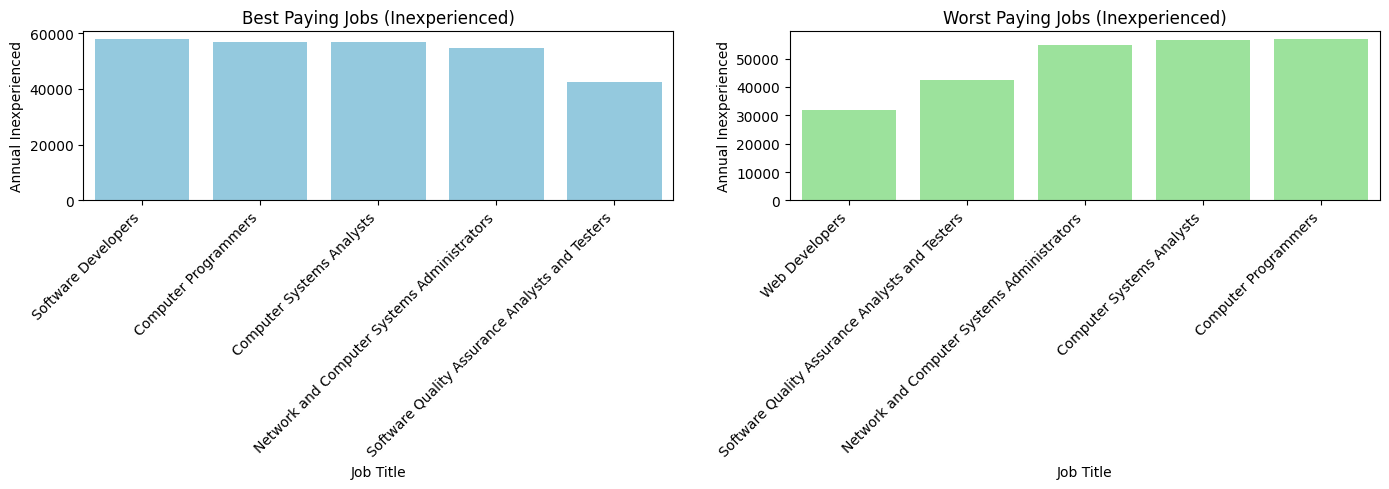

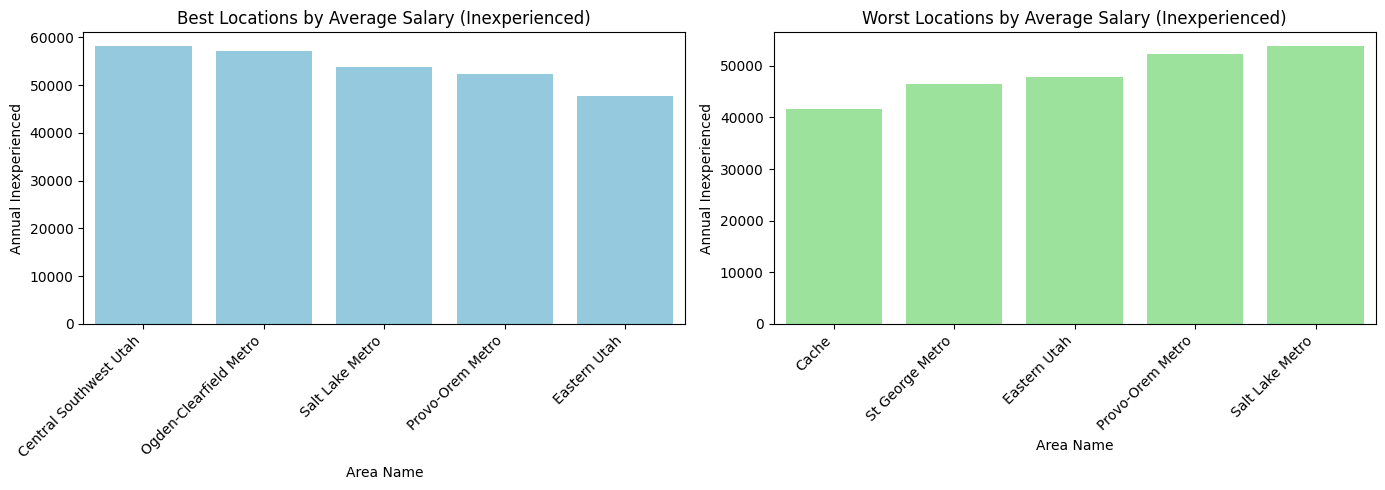

/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_31122/2301503150.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_31122/2301503150.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


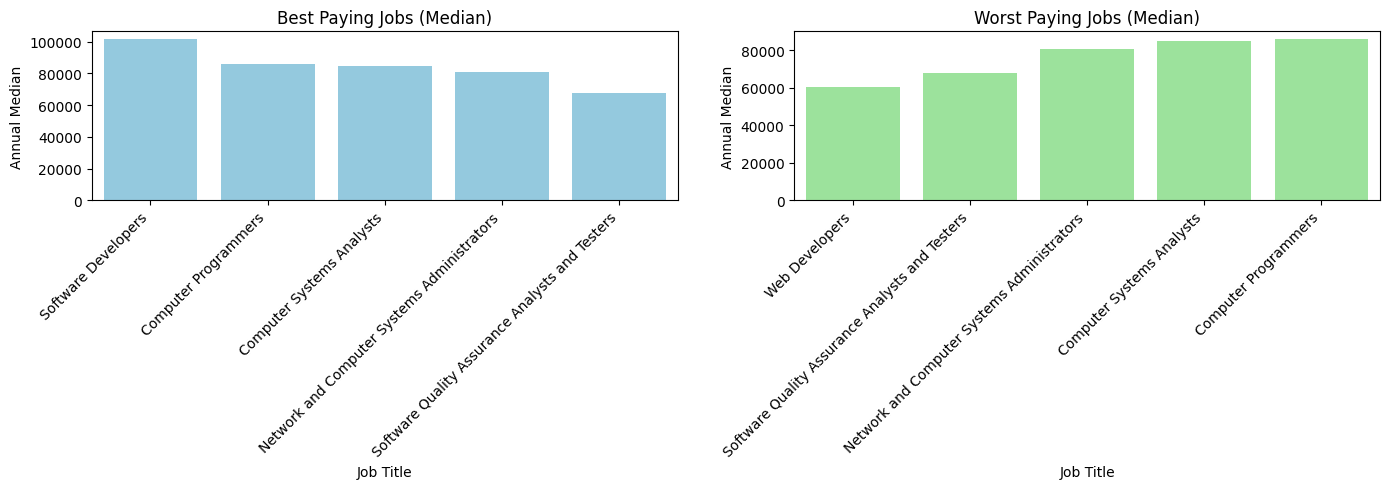

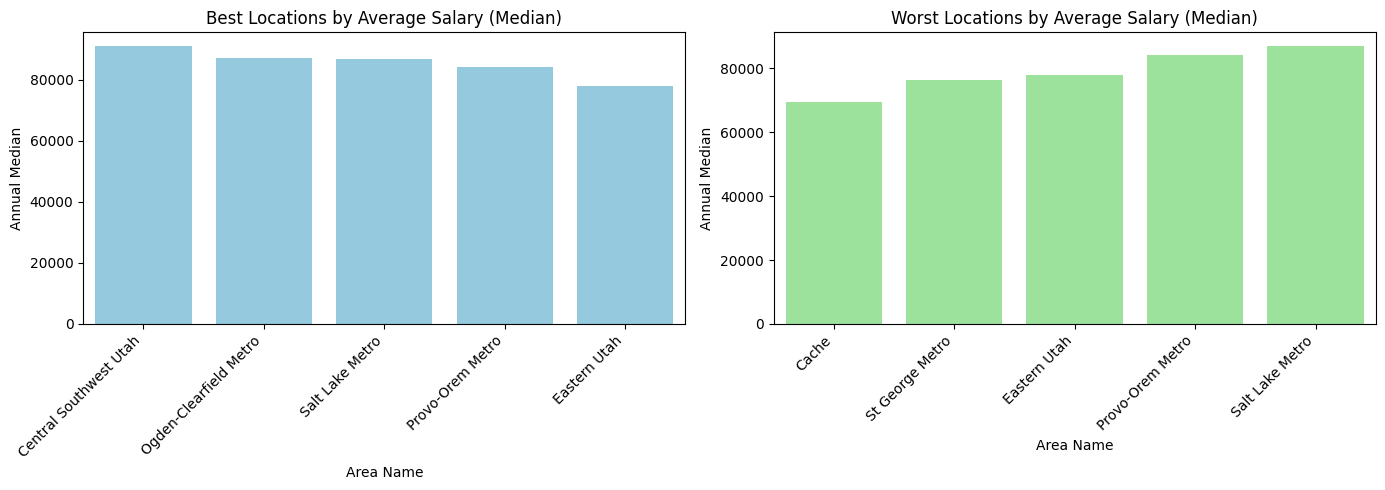

In [23]:
# pre-processing wages dataset
df = pd.read_excel("wages.xlsx")
wage_df = df[~df['Area Name'].isin(['United States', 'Statewide'])]

def wagesAnalysis(wage_data, inexperienced=True):
    adj = 'Inexperienced' if inexperienced else 'Median'
    
    # analysis of average salary by job title
    average_salary_by_job = wage_data.groupby('Job Title')[f'Annual {adj}'].mean().reset_index()
    best_paying_jobs = average_salary_by_job.sort_values(by=f'Annual {adj}', ascending=False).head()
    worst_paying_jobs = average_salary_by_job.sort_values(by=f'Annual {adj}', ascending=True).head()
    
    # plotting best and worst paying jobs
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    sns.barplot(x='Job Title', y=f'Annual {adj}', data=best_paying_jobs, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Best Paying Jobs ({adj})')
    sns.barplot(x='Job Title', y=f'Annual {adj}', data=worst_paying_jobs, ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Worst Paying Jobs ({adj})')
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()

    # analysis of average salary by area
    average_salary_by_area = wage_data.groupby('Area Name')[f'Annual {adj}'].mean().reset_index()
    best_locations = average_salary_by_area.sort_values(by=f'Annual {adj}', ascending=False).head()
    worst_locations = average_salary_by_area.sort_values(by=f'Annual {adj}', ascending=True).head()
    
    # plotting best and worst locations for salaries vertically
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    sns.barplot(x='Area Name', y=f'Annual {adj}', data=best_locations, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Best Locations by Average Salary ({adj})')
    sns.barplot(x='Area Name', y=f'Annual {adj}', data=worst_locations, ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Worst Locations by Average Salary ({adj})')
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

wagesAnalysis(wage_df, inexperienced=True)
wagesAnalysis(wage_df, inexperienced=False)

# Analysis 1: Salary vs Cost of Living

In [28]:
# pre-processing. get the combined dataset
df = pd.read_excel("wages.xlsx")
wage_df = df[~df['Area Name'].isin(['United States', 'Statewide']).copy()]
wage_df.rename(columns={'Area Name': 'County'}, inplace=True)

# apply the mapping to wage_df to create a new 'Mapped County' column
wage_df['Mapped County'] = wage_df['County'].map({
    'Cache': 'Cache County',
    'Central Southwest Utah': 'Beaver County',
    'Eastern Utah': 'Carbon County',
    'Ogden-Clearfield Metro': 'Weber County',
    'Provo-Orem Metro': 'Utah County',
    'Salt Lake Metro': 'Salt Lake County',
    'St George Metro': 'Washington County'
})

combined_df = pd.merge(wage_df, ut_df, left_on='Mapped County', right_on='County')

# - An Affordability Index > 1 means income is greater than the cost of living (more affordable).
# - An Affordability Index < 1 means income is less than the cost of living (less affordable).
combined_df['Affordability Index'] = combined_df['Annual Median'] / combined_df['Total.1']

/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_31122/1147711216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_df.rename(columns={'Area Name': 'County'}, inplace=True)
/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_31122/1147711216.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_df['Mapped County'] = wage_df['County'].map({


,Job Title,County_x,Hourly Inexperienced,Hourly Median,Annual Inexperienced,Annual Median,Current Employment,Projected Employment,Annual %Change,Total Annual Openings,...,Healthcare.1,Other Necessities .1,Childcare.1,Taxes.1,Total.1,median_family_income,num_counties_in_st,st_cost_rank,st_med_aff_rank,st_income_rank
0,Software Developers,Cache,26.65,41.01,55440.0,85300.0,NaN,NaN,NaN,NaN,...,5568,4104,0,6660,41484,69871.40625,29,21,11,18.0
1,Software Developers,Cache,26.65,41.01,55440.0,85300.0,NaN,NaN,NaN,NaN,...,8592,6060,8736,8640,65400,69871.40625,29,21,11,18.0
2,Software Developers,Cache,26.65,41.01,55440.0,85300.0,NaN,NaN,NaN,NaN,...,11628,7020,16920,11784,85584,69871.40625,29,21,11,18.0
3,Software Developers,Cache,26.65,41.01,55440.0,85300.0,NaN,NaN,NaN,NaN,...,14664,9720,19440,16536,107208,69871.40625,29,21,11,18.0
4,Software Developers,Cache,26.65,41.01,55440.0,85300.0,NaN,NaN,NaN,NaN,...,17700,10620,19440,19464,117348,69871.40625,29,21,11,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,Network and Computer Systems Administrators,St George Metro,22.62,34.63,47050.0,72030.0,80.0,119.0,4.88,10.0,...,11940,6948,0,8940,62316,71597.50000,29,4,12,12.0
416,Network and Computer Systems Administrators,St George Metro,22.62,34.63,47050.0,72030.0,80.0,119.0,4.88,10.0,...,15192,8508,8736,11808,85320,71597.50000,29,4,12,12.0
417,Network and Computer Systems Administrators,St George Metro,22.62,34.63,47050.0,72030.0,80.0,119.0,4.88,10.0,...,18444,9384,16920,13524,102864,71597.50000,29,4,12,12.0
418,Network and Computer Systems Administrators,St George Metro,22.62,34.63,47050.0,72030.0,80.0,119.0,4.88,10.0,...,21696,12468,19440,18240,125880,71597.50000,29,4,12,12.0


/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_31122/3332690159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Affordability Index'] = df['Annual Median'] / df['Total.1']


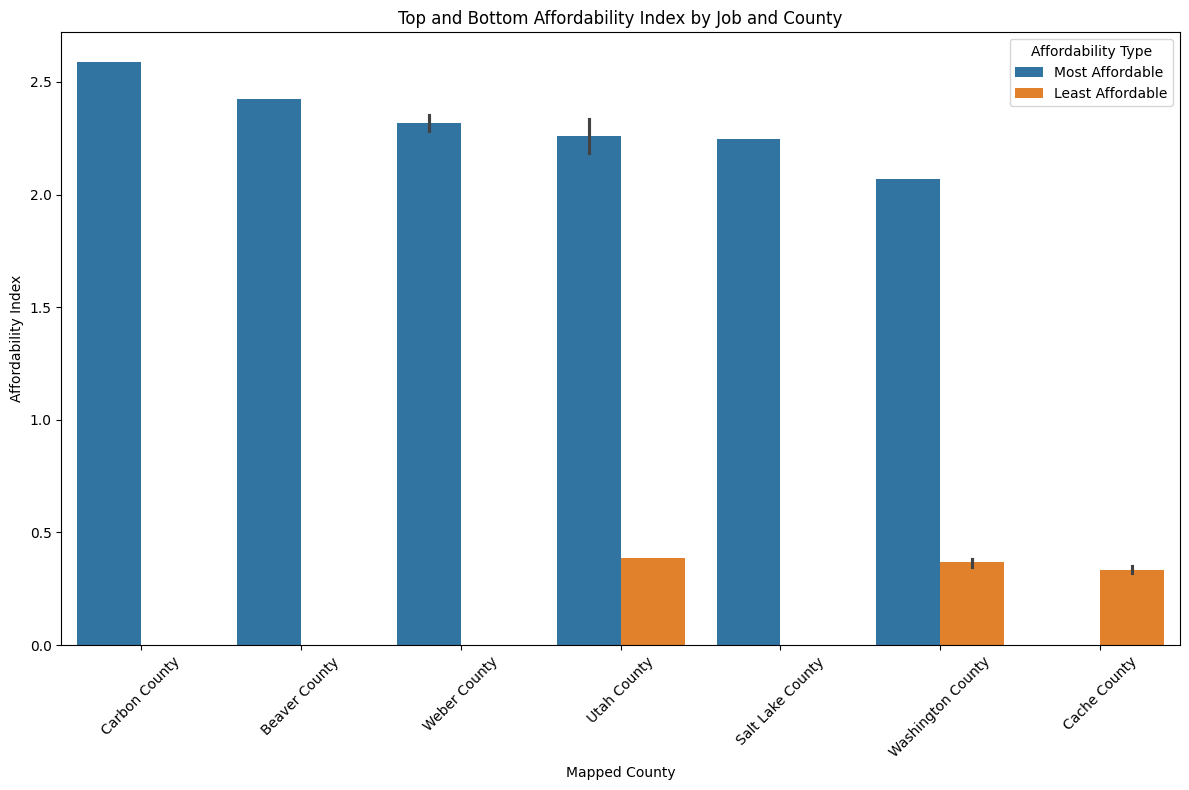

Top 8 Most Affordable:
                     Job Title      Mapped County  Annual Median  Total.1  \
120        Software Developers      Carbon County       104020.0    40152   
60         Software Developers      Beaver County        98720.0    40728   
180        Software Developers       Weber County       106680.0    45324   
240        Software Developers        Utah County       111240.0    47640   
190  Computer Systems Analysts       Weber County       103370.0    45324   
300        Software Developers   Salt Lake County       106880.0    47532   
260       Computer Programmers        Utah County       104110.0    47640   
360        Software Developers  Washington County        97390.0    47076   

     Affordability Index  
120             2.590656  
60              2.423885  
180             2.353720  
240             2.335013  
190             2.280690  
300             2.248590  
260             2.185348  
360             2.068782  

Top 8 Least Affordable:
               

In [41]:
def affordabilityAnalysis(num):
    # Exclude rows where 'Annual Median' or 'Total.1' is NaN
    df = combined_df.dropna(subset=['Annual Median', 'Total.1'])

    # Calculate the affordability index
    df['Affordability Index'] = df['Annual Median'] / df['Total.1']
    sorted_df = df.sort_values(by='Affordability Index', ascending=False)
    
    # Get the top 5 most affordable
    most_affordable = sorted_df.head(num)
    
    # Get the top 5 least affordable
    least_affordable = sorted_df.tail(num)

    print(f"Top {num} Most Affordable:")
    print(most_affordable[['Job Title', 'Mapped County', 'Annual Median', 'Total.1', 'Affordability Index']])
    print(f"\nTop {num} Least Affordable:")
    print(least_affordable[['Job Title', 'Mapped County', 'Annual Median', 'Total.1', 'Affordability Index']])
        
affordabilityAnalysis(8)